In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import sys
sys.path.append('../')

from proxy_apps.framework.gpu import GPU
from proxy_apps.apps import ClimateLSTMProxyAppPT, ClimateCNNProxyAppPT
from proxy_apps.data.grid import TransientDataset

2023-01-04 23:43:16.052946: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Initialize App

In [2]:
# get the framework
framework = GPU(
    machine_name="deception",
    mgpu_strategy="DDP"
)

# get the interface
interface = framework.use_pytorch()

# load the proxy app
app = ClimateCNNProxyAppPT("gpu")

[INFO] Device Type: cpu
[WARNING] No GPUs found, falling back to CPUs
[INFO] Python Data Type: float64
[INFO] Framework Data Type: torch.float64


In [3]:
# init app manager
interface.init_app_manager(
    app=app,
    app_name="ClimateLSTMProxyAppPT",
    output_dir="/qfs/people/jain432/pacer_remote/output/test/",
    mixed_precision_support=True,
    mgpu_support=True
)


[INFO] Selected App: ClimateLSTMProxyAppPT
[INFO] Output Data Directory: /qfs/people/jain432/pacer_remote/output/test
[INFO] App Supports Mixed Precision: True
[INFO] App Supports MGPUs: True
[INFO] Disabling Multi-GPU Support. To use multiple gpus, provide a valid Multi-GPU strategy (HVD/DDP) when initializing the framework.


## Load Data and Prepare Dataloader

In [4]:
# initialize data manager
data_manager = interface.init_data_manager(
    data_dir="/qfs/people/jain432/pacer_remote/data/ISDProcessed/",#"/qfs/people/jain432/pacer_remote/data/NewTestScenarios/",
    file_format="*",
    data_manager_type="TimeSeries",
    train_files=2,
    test_files="/qfs/people/jain432/pacer_remote/data/ISDProcessed/",#"/qfs/people/jain432/pacer_remote/data/TrainingDataIEEE68bus/",
    val_files=0,
    shuffle=True
)


[INFO] Training Data Directory: /qfs/people/jain432/pacer_remote/data/ISDProcessed/
[INFO] Found 49 `*` files
[INFO] Training on 2/49 `*` files
[INFO] Validation on 0/49 `*` files
[INFO] Testing on 49/49 `*` files
[INFO] Number of training files (per GPU): 2
[INFO] Number of validation files (per GPU): 0


In [5]:
print(
    "Train (%d-%d): %s\nVal (%d-%d): %s\nTest (%d-%d): %s" 
    %(
        len(data_manager._TRAIN_FILES),
        data_manager._N_TRAIN_FILES,
        data_manager._TRAIN_DATA_DIR, 
        len(data_manager._VAL_FILES),
        data_manager._N_VAL_FILES,
        data_manager._VAL_DATA_DIR,
        len(data_manager._TEST_FILES),
        data_manager._N_TEST_FILES,
        data_manager._TEST_DATA_DIR
    )
)

Train (2-2): /qfs/people/jain432/pacer_remote/data/ISDProcessed/
Val (0-0): /qfs/people/jain432/pacer_remote/data/ISDProcessed/
Test (49-49): /qfs/people/jain432/pacer_remote/data/ISDProcessed/


In [6]:
# load training data
load_prep_params = {
	"dataloader": "torch.utils.data.Dataset",
	"n_rows": 8760,
	"n_cols": 326,
	"repeat_cols": 1,
	"iw_params": {
		"window_size": 60,
		"shift_size": 1,
		"stride": 1,
		"start_at": 0,
		"leave_last": 33
	},
	"ow_params": {
		"window_size": 30,
		"shift_size": 1,
		"stride": 1,
		"start_at": 60,
		"leave_last": 3
	}
}
# training data
training_data = interface.load_data(
    data_files=data_manager._TRAIN_FILES,
    data_params=load_prep_params,
    sampler=None,
	batch_size=64
)
# test data
test_data = interface.load_data(
    data_files=data_manager._TEST_FILES[:2],
    data_params=load_prep_params,
    sampler=None
)

## Model Training

### PyTorch

In [7]:
# compare actual and window data
def compare_lineplots(ax1_data, ax1_label, ax2_data, ax2_label):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    ax=axes[0]
    ax.plot(ax1_data);
    ax.set_title(ax1_label)
    ax=axes[1]
    ax.plot(ax2_data);
    ax.set_title(ax2_label)
    fig.tight_layout()

In [11]:
data_params = {
    "bw_size": 60,
    "fw_size": 30,
    "n_features": 326
}
opt_parameters = {
    "learning_rate"      : 5e-4,
    "momentum"      : 0.0,
    "weight_decay"  : 3e-4	
}
# train model
interface.init_training_engine(
    model_name="gpu_ng8_nc0_e50_b2048_dfp64_mpguDDP_prof0",
    model_dir="/qfs/people/jain432/pacer_remote/models/ProxyTSPRD_IPDPS/ClimateCNNProxyAppPT/",
    data_params=data_params,
    opt_params=opt_parameters,
    criterion_params=None
)

[INFO] Model Parameters:
conv_layer.weight torch.Size([256, 326, 3])
conv_layer.bias torch.Size([256])
dense_layer.weight torch.Size([9780, 256])
dense_layer.bias torch.Size([9780])


torch.Size([64, 30, 326])


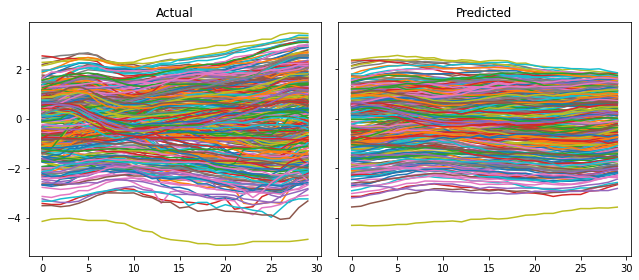

In [12]:
# build and predict on one sample
pt_model = interface.model

# select and predict
inputs, targets = iter(training_data).next()
predicted = pt_model(inputs)
print(predicted.shape)

# compare prediction with actuals
compare_lineplots(
    targets[0, :, :], "Actual",
    predicted.detach().numpy()[0, :, :], "Predicted"
)


In [10]:
# # train the model
# interface.train(
#     training_data=training_data,
#     n_epochs=20
# )

# # after training comparison
# predicted = pt_model(inputs)
# print(predicted.shape)

# # compare prediction with actuals
# compare_lineplots(
#     targets[0, :, :], "Actual",
#     predicted.detach().numpy()[0, :, :], "Predicted"
# )